In [1104]:
%load_ext dotenv
%dotenv ../../src/.env

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [1105]:
import sys
sys.path.append("../../src")

In [1106]:
from utils.logger import get_logger
_logs = get_logger(__name__)

In [1107]:
import os
from glob import glob

In [1108]:
import random

data_files = glob(os.path.join(os.getenv('SRC_DIR'), "processed/*.csv"))

In [1109]:
data_files

['../../data/processed\\01_ticker_features.csv',
 '../../data/processed\\02_time_series_dataset.csv',
 '../../data/processed\\03_clustered_dataset.csv']

In [1110]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns  
import joblib

In [1111]:
clustered_tickers=pd.read_csv(data_files[2])

In [1112]:
clustered_tickers['cluster'].value_counts()

cluster
0    433
1     10
2      4
Name: count, dtype: int64

In [1113]:
cluster_num=1

In [1114]:
df=pd.read_csv(data_files[1]).merge(clustered_tickers, on='ticker', how='inner')

In [1115]:
data = df[df['cluster'] == cluster_num].drop(columns=['cluster'])

In [1116]:
data.columns

Index(['date', 'ticker', 'open', 'close', 'low', 'high', 'volume',
       'return_pct', 'vol_5d', 'vol_10d', 'momentum_5d', 'momentum_10d',
       'sma_5d', 'sma_10d', 'hl_range_pct', 'oc_change_pct', 'avg_volume_5d',
       'avg_volume_10d'],
      dtype='object')

In [1117]:
data.shape

(17620, 18)

In [1118]:
data['date'] = pd.to_datetime(data['date'])

In [1119]:
data = data.sort_values(['ticker', 'date'])

In [1120]:
data['ticker'].unique()

array(['AAPL', 'CVX', 'F', 'IBM', 'MSFT', 'PFE', 'T', 'VZ', 'WMT', 'XOM'],
      dtype=object)

In [1121]:
data.isna().sum()

date              0
ticker            0
open              0
close             0
low               0
high              0
volume            0
return_pct        0
vol_5d            0
vol_10d           0
momentum_5d       0
momentum_10d      0
sma_5d            0
sma_10d           0
hl_range_pct      0
oc_change_pct     0
avg_volume_5d     0
avg_volume_10d    0
dtype: int64

In [1122]:
cutoff_date='2016-01-01'

In [1123]:
train_data = data[data['date'] < cutoff_date].copy()
test_data  = data[data['date'] >= cutoff_date].copy()

In [1124]:
print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)

Train shape: (15100, 18)
Test shape: (2520, 18)


In [1125]:
train_data.head(10)

,date,ticker,open,close,low,high,volume,return_pct,vol_5d,vol_10d,momentum_5d,momentum_10d,sma_5d,sma_10d,hl_range_pct,oc_change_pct,avg_volume_5d,avg_volume_10d
3524,2010-01-04,AAPL,30.490000,30.572857,30.340000,30.642857,123432400.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.990606,0.271752,0.0,0.0
3525,2010-01-05,AAPL,30.657143,30.625713,30.464285,30.798571,150476200.0,0.172887,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.091520,-0.102519,0.0,0.0
3526,2010-01-06,AAPL,30.625713,30.138571,30.107143,30.747143,138040000.0,-1.590633,0.000000,0.0,0.000000,0.0,0.000000,0.000000,2.123523,-1.590633,0.0,0.0
3527,2010-01-07,AAPL,30.250000,30.082857,29.864286,30.285715,119282800.0,-0.184858,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.400893,-0.552538,0.0,0.0
3528,2010-01-08,AAPL,30.042856,30.282858,29.865715,30.285715,111902700.0,0.664833,0.000000,0.0,0.000000,0.0,30.340571,0.000000,1.386924,0.798864,128626820.0,0.0
3529,2010-01-11,AAPL,30.400000,30.015715,29.778572,30.428572,115557400.0,-0.882160,0.887687,0.0,-0.557142,0.0,30.229143,0.000000,2.165531,-1.264095,127051820.0,0.0
3530,2010-01-12,AAPL,29.884285,29.674286,29.488571,29.967142,148614900.0,-1.137500,0.882981,0.0,-0.951427,0.0,30.038857,0.000000,1.612746,-0.702708,126679560.0,0.0
3531,2010-01-13,AAPL,29.695715,30.092857,29.157143,30.132856,151473000.0,1.410553,1.064732,0.0,-0.045713,0.0,30.029715,0.000000,3.242344,1.337373,129366160.0,0.0
3532,2010-01-14,AAPL,30.015715,29.918571,29.860001,30.065714,108223500.0,-0.579161,1.093664,0.0,-0.164286,0.0,29.996857,0.000000,0.687577,-0.323641,127154300.0,0.0
3533,2010-01-15,AAPL,30.132856,29.418571,29.410000,30.228571,148516900.0,-1.671203,1.178432,0.0,-0.864286,0.0,29.824000,30.082286,2.782498,-2.370452,134477140.0,131551980.0


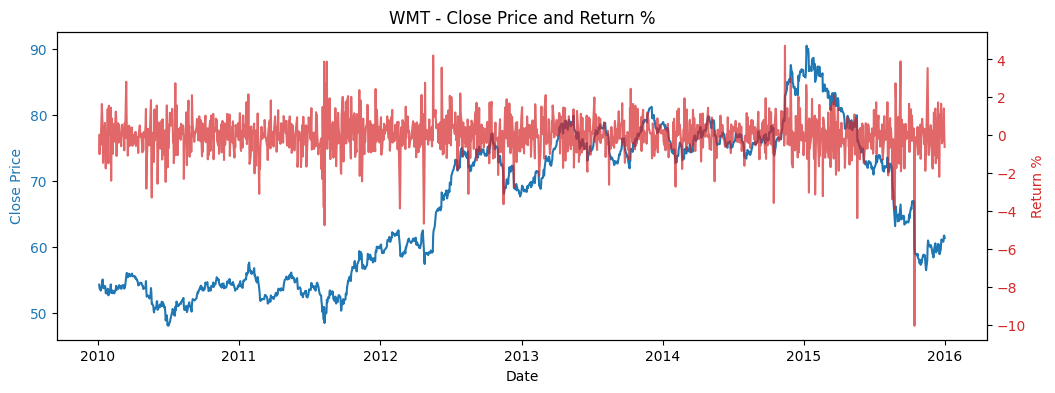

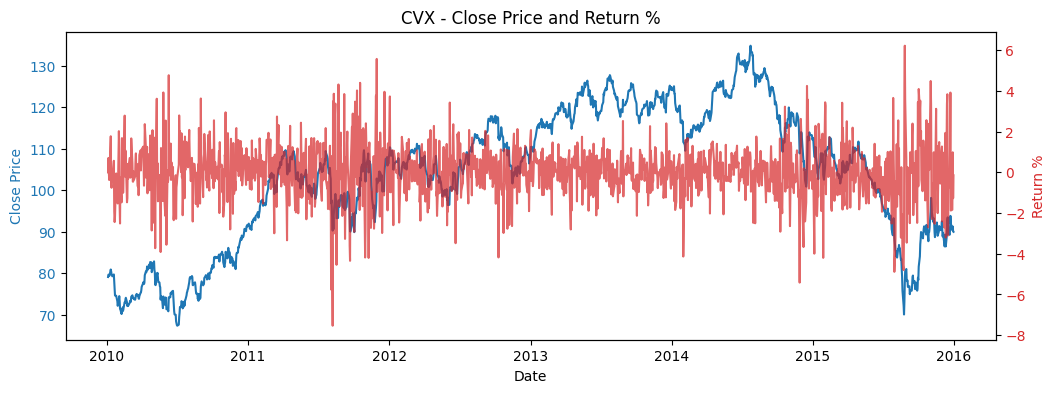

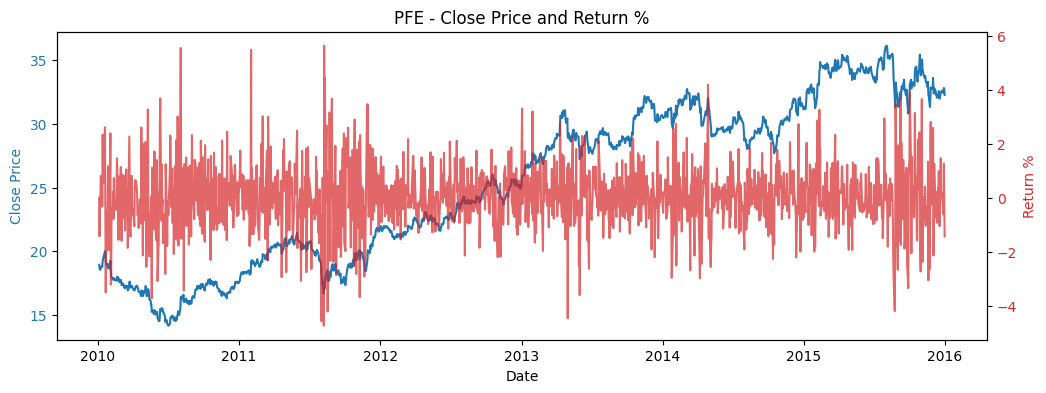

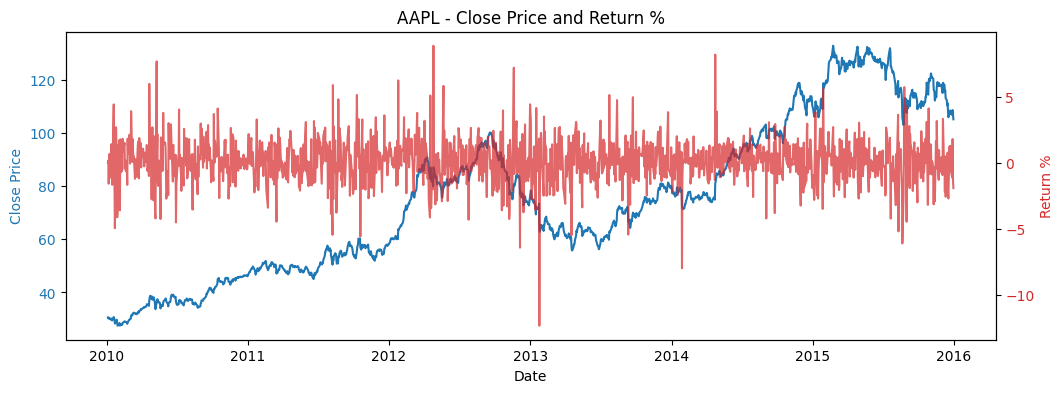

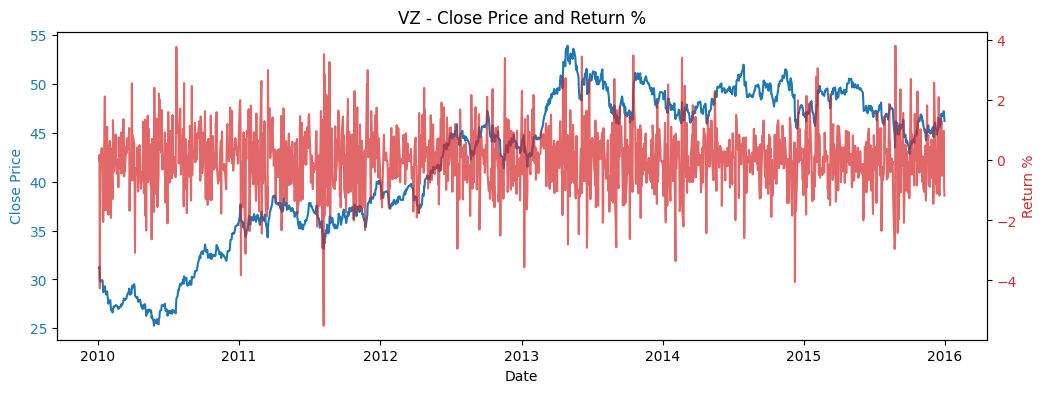

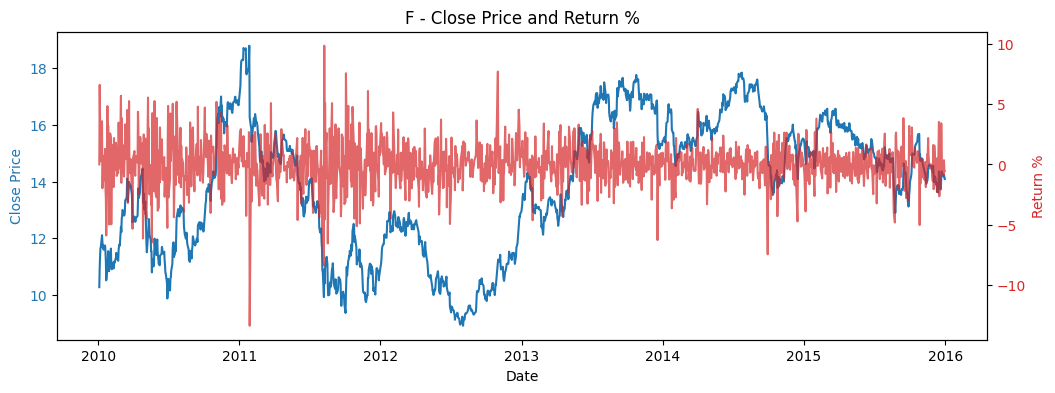

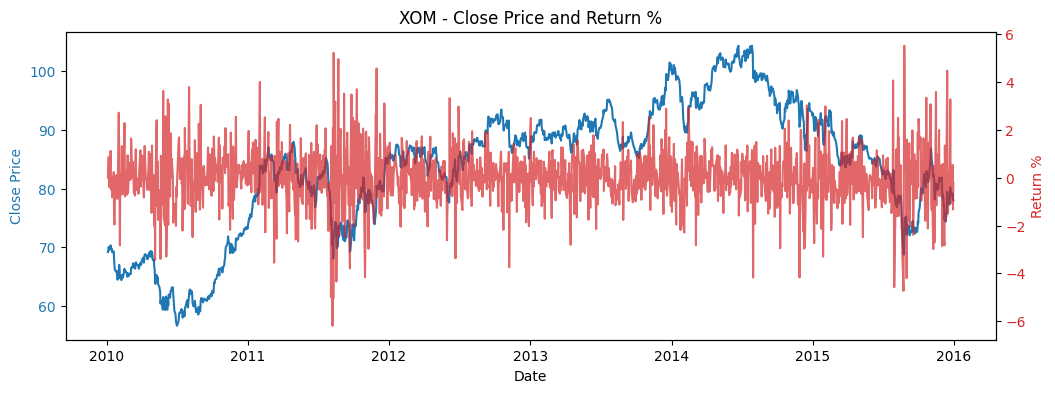

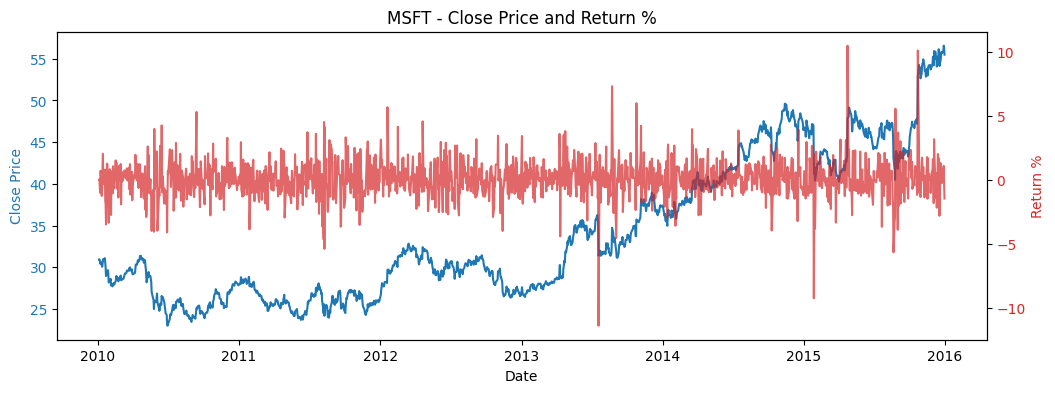

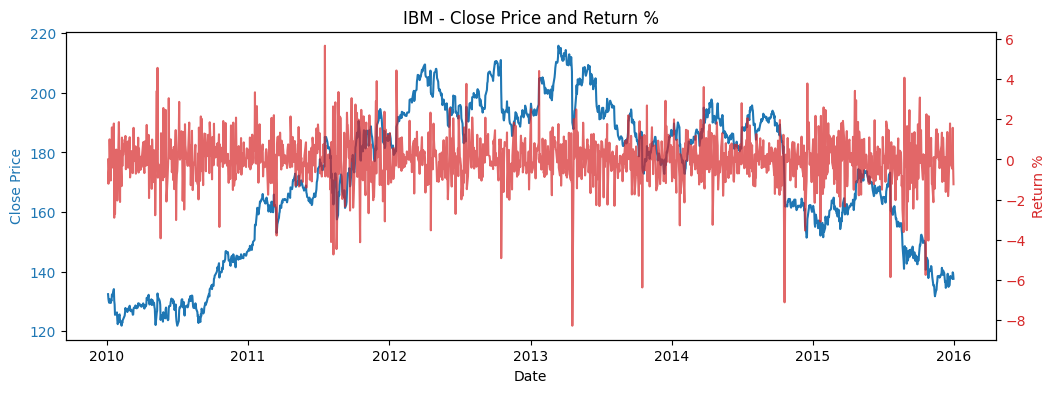

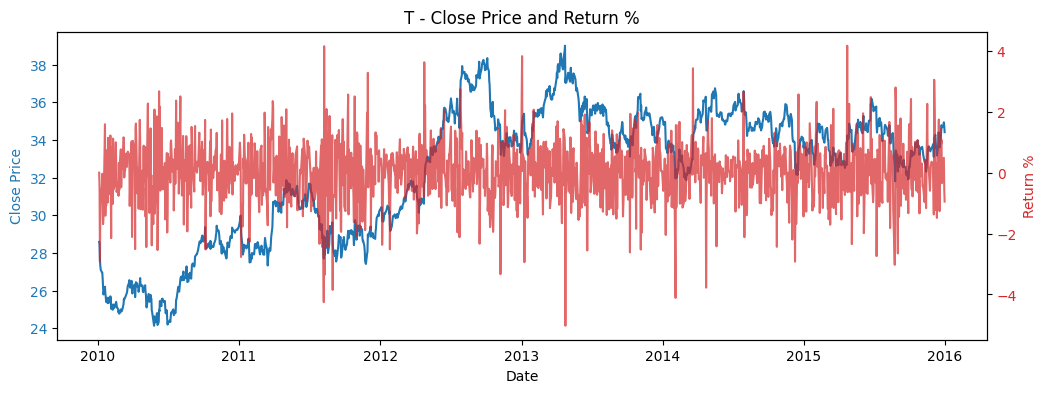

In [1126]:
np.random.seed(42)
sample_tickers = np.random.choice(train_data['ticker'].unique(), size=len(data['ticker'].unique()), replace=False)

# Plot each stock's close price and return_pct
for ticker in sample_tickers:
    df_stock = train_data[train_data['ticker'] == ticker].sort_values('date')
    
    fig, ax1 = plt.subplots(figsize=(12, 4))

    color = 'tab:blue'
    ax1.set_title(f"{ticker} - Close Price and Return %")
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close Price', color=color)
    ax1.plot(df_stock['date'], df_stock['close'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Return %', color=color)
    ax2.plot(df_stock['date'], df_stock['return_pct'], color=color, alpha=0.7)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()

***1. Naive Forecast***

**a. Use previous day return percentage as next day return**
- *Predict return_pct of day t as same as day t-1*
- *Evaluate using RMSE or MAPE per ticker*

In [1127]:
test_data["return_pred_naive"] = (
    test_data.groupby("ticker")["return_pct"].shift(1).fillna(0)
)

In [1128]:
y_true = test_data["return_pct"]
y_pred = test_data["return_pred_naive"]

In [1129]:
mae_naive = mean_absolute_error(y_true, y_pred)
rmse_naive = np.sqrt(mean_squared_error(y_true, y_pred))


In [1130]:
print(f"Naive Baseline (Lag-1 Return) — MAE: {mae_naive:.4f}, RMSE: {rmse_naive:.4f}")

Naive Baseline (Lag-1 Return) — MAE: 1.3527, RMSE: 1.8779


**b. Use previous day close to predict next dat close and they calculate the return percentage**

In [1131]:
test_data["pred_close"] = (
    test_data.groupby("ticker")["close"].shift(1).fillna(0)
)

In [1132]:
yesterday_close = test_data.groupby("ticker")["close"].shift(1).fillna(0)

In [1133]:
test_data["pred_ret_pct"] = ((test_data["pred_close"] / yesterday_close) - 1) * 100

In [1134]:
y_true = test_data["return_pct"].fillna(0)
y_pred = test_data["pred_ret_pct"].fillna(0)

In [1135]:
mae_naive = mean_absolute_error(y_true, y_pred)
rmse_naive = np.sqrt(mean_squared_error(y_true, y_pred))

In [1136]:
print(f"Naive Baseline (Lag-1 close) — MAE: {mae_naive:.4f}, RMSE: {rmse_naive:.4f}")

Naive Baseline (Lag-1 close) — MAE: 0.9158, RMSE: 1.3039


**c. 5-Day Simple Moving Average (SMA5)**

In [1137]:
test_data["pred_close_sma5"] = (
    test_data.groupby("ticker")["sma_5d"].shift(1).fillna(0)
)

In [1138]:
yesterday_close = test_data.groupby("ticker")["close"].shift(1).fillna(0)

In [1139]:
test_data["pred_ret_pct"] = ((test_data["pred_close_sma5"] / yesterday_close) - 1) * 100

In [1140]:
y_true = test_data["return_pct"].fillna(0)
y_pred = test_data["pred_ret_pct"].fillna(0)

In [1141]:
mae_naive = mean_absolute_error(y_true, y_pred)
rmse_naive = np.sqrt(mean_squared_error(y_true, y_pred))

In [1142]:
print(f"Naive Baseline (Lag-1 SMA5) — MAE: {mae_naive:.4f}, RMSE: {rmse_naive:.4f}")

Naive Baseline (Lag-1 SMA5) — MAE: 1.3809, RMSE: 1.8921


**d. 10-Day Simple Moving Average (SMA5)**

In [1143]:
test_data["pred_close_sma10"] = (
    test_data.groupby("ticker")["sma_10d"].shift(1).fillna(0)
)

In [1144]:
yesterday_close = test_data.groupby("ticker")["close"].shift(1).fillna(0)

In [1145]:
test_data["pred_ret_pct"] = ((test_data["pred_close_sma10"] / yesterday_close) - 1) * 100

In [1146]:
y_true = test_data["return_pct"].fillna(0)
y_pred = test_data["pred_ret_pct"].fillna(0)

In [1147]:
mae_naive = mean_absolute_error(y_true, y_pred)
rmse_naive = np.sqrt(mean_squared_error(y_true, y_pred))

In [1148]:
print(f"Naive Baseline (Lag-1 SMA10) — MAE: {mae_naive:.4f}, RMSE: {rmse_naive:.4f}")

Naive Baseline (Lag-1 SMA10) — MAE: 1.8335, RMSE: 2.4560


***Linear Regression Model***

In [1149]:
train_data.head()

,date,ticker,open,close,low,high,volume,return_pct,vol_5d,vol_10d,momentum_5d,momentum_10d,sma_5d,sma_10d,hl_range_pct,oc_change_pct,avg_volume_5d,avg_volume_10d
3524,2010-01-04,AAPL,30.490000,30.572857,30.340000,30.642857,123432400.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.990606,0.271752,0.0,0.0
3525,2010-01-05,AAPL,30.657143,30.625713,30.464285,30.798571,150476200.0,0.172887,0.0,0.0,0.0,0.0,0.000000,0.0,1.091520,-0.102519,0.0,0.0
3526,2010-01-06,AAPL,30.625713,30.138571,30.107143,30.747143,138040000.0,-1.590633,0.0,0.0,0.0,0.0,0.000000,0.0,2.123523,-1.590633,0.0,0.0
3527,2010-01-07,AAPL,30.250000,30.082857,29.864286,30.285715,119282800.0,-0.184858,0.0,0.0,0.0,0.0,0.000000,0.0,1.400893,-0.552538,0.0,0.0
3528,2010-01-08,AAPL,30.042856,30.282858,29.865715,30.285715,111902700.0,0.664833,0.0,0.0,0.0,0.0,30.340571,0.0,1.386924,0.798864,128626820.0,0.0


In [1150]:
from sklearn.linear_model import LinearRegression

In [1151]:
# Create lagged return features
# We include the returns from 1 and 2 days prior as predictors.
# Lagged features capture short-term autocorrelation in returns.

for lag in [1, 2]:
    train_data[f'return_lag_{lag}'] = train_data.groupby('ticker')['return_pct'].shift(lag)
    test_data[f'return_lag_{lag}'] = test_data.groupby('ticker')['return_pct'].shift(lag)

In [1152]:
# Add time-based features to capture seasonality
# Day-of-week can capture patterns like Monday/Friday effects.

train_data['day_of_week'] = train_data['date'].dt.dayofweek
test_data['day_of_week'] = test_data['date'].dt.dayofweek

In [1153]:
# Fourier terms for weekly seasonality (sin/cos transforms)
# These help capture cyclical patterns more smoothly than just integer day values.

train_data['sin_week'] = np.sin(2 * np.pi * train_data['day_of_week'] / 7)
train_data['cos_week'] = np.cos(2 * np.pi * train_data['day_of_week'] / 7)
test_data['sin_week'] = np.sin(2 * np.pi * test_data['day_of_week'] / 7)
test_data['cos_week'] = np.cos(2 * np.pi * test_data['day_of_week'] / 7)

In [1154]:
# Select features for the model
# We combine lagged returns, momentum, moving averages, volatility,
# and the seasonal features we just created.

feature_cols = [
    'return_lag_1', 'return_lag_2', 
    'momentum_5d', 'momentum_10d',
    'sma_5d', 'sma_10d',
    'hl_range_pct', 'oc_change_pct',
    'vol_5d', 'vol_10d', 'avg_volume_5d', 'avg_volume_10d',
    'sin_week', 'cos_week'
]

In [1155]:
# Prepare feature matrices and handle missing values
# Lagged features will have NaNs for the first rows per ticker, which we fill with 0.

X_train = train_data[feature_cols].fillna(0)
X_test = test_data[feature_cols].fillna(0)


In [1156]:
# Target variable

y_train = train_data['return_pct'].fillna(0)
y_test = test_data['return_pct'].fillna(0)

In [1157]:
# Standardize numeric features
# Standardizing helps linear regression converge faster and ensures
# features are on a comparable scale.

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [1158]:
# Train Linear Regression
# We fit a simple Ordinary Least Squares (OLS) model.

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [1159]:
# Predict and evaluate
# Compare predictions against true returns using MAE and RMSE.

y_pred = lr_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Linear Regression Baseline (grouped by ticker) — MAE: {mae:.4f}, RMSE: {rmse:.4f}")

Linear Regression Baseline (grouped by ticker) — MAE: 0.4905, RMSE: 0.8112


In [1160]:
# compare with actual returns
comparison = pd.DataFrame({
    'actual_return': y_test,
    'predicted_return': y_pred
})
print("\nComparison of actual vs predicted (first 10 rows):")
print(comparison.head(10))


Comparison of actual vs predicted (first 10 rows):
      actual_return  predicted_return
5034       0.085499          1.941072
5035      -2.505932         -3.172863
5036      -1.956968         -0.635837
5037      -4.220457         -3.002728
5038       0.528773         -1.776020
5039       1.619224         -0.553670
5040       1.451335         -0.687002
5041      -2.571028         -3.211234
5042       2.187081          1.614756
5043      -2.401527          1.101239


In [1161]:
import pickle

In [1162]:
MODEL_DIR = os.path.join(os.getenv('MODEL_DIR', '.'), "lr")
os.makedirs(MODEL_DIR, exist_ok=True)

In [1163]:
lr_model_path = os.path.join(MODEL_DIR, "linear_regression_baseline.pkl")

In [1164]:
with open(lr_model_path, "wb") as f:
    pickle.dump(lr_model, f)

In [1165]:
print(f"Model saved successfully at: {lr_model_path}")

Model saved successfully at: ../../models/lr\linear_regression_baseline.pkl


In [1166]:
from sklearn.ensemble import RandomForestRegressor

In [1167]:
# Initialize Random Forest
rf_model = RandomForestRegressor(
    n_estimators=200,        # number of trees
    max_depth=8,             # control tree depth to prevent overfitting
    min_samples_leaf=5,      # minimum samples per leaf
    random_state=42,
    n_jobs=-1
)

In [1168]:
# Train the model
rf_model.fit(X_train, y_train)

,n_estimators,200
,criterion,'squared_error'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [1169]:
# Predict and evaluate
y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Random Forest Baseline (grouped by ticker) — MAE: {mae:.4f}, RMSE: {rmse:.4f}")

Random Forest Baseline (grouped by ticker) — MAE: 0.4750, RMSE: 0.7987


In [1170]:
# Sample predictions
print("\nSample predictions (first 10 rows):")
sample_preds = pd.DataFrame({
    'actual_return': y_test,
    'predicted_return': y_pred
})
print(sample_preds.head(10))


Sample predictions (first 10 rows):
      actual_return  predicted_return
5034       0.085499          1.003469
5035      -2.505932         -2.955613
5036      -1.956968         -0.539564
5037      -4.220457         -2.695375
5038       0.528773         -1.462710
5039       1.619224         -0.450007
5040       1.451335         -0.757846
5041      -2.571028         -3.733214
5042       2.187081          1.596376
5043      -2.401527          1.658941


In [1171]:
MODEL_DIR = os.path.join(os.getenv('MODEL_DIR', '.'), "rf")
os.makedirs(MODEL_DIR, exist_ok=True)

In [1172]:
rf_model_path = os.path.join(MODEL_DIR, "random_forest_baseline.pkl")

In [1173]:
with open(rf_model_path, "wb") as f:
    pickle.dump(rf_model, f)

print(f"Model saved successfully at: {rf_model_path}")

Model saved successfully at: ../../models/rf\random_forest_baseline.pkl
